<a href="https://colab.research.google.com/github/eduschadesoares/OPENLP_FILES/blob/master/TRAB_SIAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exemplo adaptado de:
https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6

- Adaptamos a Siamese mudando a função de custo e o esquema de rotulação

Importando a bibliotecas necessárias

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
#import keras
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNet

Preparando os Dados

In [106]:
# scale pixels
def prep_pixels(train):
	# convert from integers to floats
	train_norm = train.astype('float32')
#	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
#	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm

base_dir = r'/content/drive/My Drive/fruits-360/Training/'
train_test_split = 0.7  # percentagem a ser utilizada para treinamento
samples_per_class = 5  # número de amostras por classe (ou categoria)

# Lê todos os diretórios
folder_list = os.listdir(base_dir)
print(len(folder_list), "categorias encontradas na base")

# Cria as listas de categorias, instâncias e rótulos para treinamento
category_list = []
x = []
y = []
y_label = 0

# Utiliza apenas 5 imagens por categoria
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    print(folder_name)
    for file_name in files_list[:samples_per_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((224, 224))))
        print(y_label)
        y.append(y_label)
    y_label+=1
    category_list.append(temp)

# Normaliza os dados entre 0 e 1
category_list = np.asarray(category_list)
x = np.asarray(x)
y = np.asarray(y)
x = prep_pixels(x)

print('X, Y shape',x.shape, y.shape, category_list.shape)





131 categorias encontradas na base
Tomato Maroon
0
0
0
0
0
Tomato Yellow
1
1
1
1
1
Watermelon
2
2
2
2
2
Tomato not Ripened
3
3
3
3
3
Tomato Heart
4
4
4
4
4
Walnut
5
5
5
5
5
Tomato Cherry Red
6
6
6
6
6
Tomato 4
7
7
7
7
7
Tomato 3
8
8
8
8
8
Salak
9
9
9
9
9
Tomato 2
10
10
10
10
10
Tangelo
11
11
11
11
11
Tomato 1
12
12
12
12
12
Strawberry
13
13
13
13
13
Strawberry Wedge
14
14
14
14
14
Tamarillo
15
15
15
15
15
Redcurrant
16
16
16
16
16
Raspberry
17
17
17
17
17
Potato White
18
18
18
18
18
Potato Red
19
19
19
19
19
Quince
20
20
20
20
20
Rambutan
21
21
21
21
21
Pomelo Sweetie
22
22
22
22
22
Potato Red Washed
23
23
23
23
23
Pomegranate
24
24
24
24
24
Potato Sweet
25
25
25
25
25
Plum 2
26
26
26
26
26
Plum 3
27
27
27
27
27
Pepper Red
28
28
28
28
28
Pineapple
29
29
29
29
29
Physalis
30
30
30
30
30
Plum
31
31
31
31
31
Pitahaya Red
32
32
32
32
32
Pepper Yellow
33
33
33
33
33
Physalis with Husk
34
34
34
34
34
Pineapple Mini
35
35
35
35
35
Pepper Orange
36
36
36
36
36
Pepper Green
37
37
37
37
37
Pear 

Dividindo a base em treinamento e teste)




In [107]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes para treinamento e', test_size, ' classes para teste')

train_files = train_size * samples_per_class

# Separando a base de treinamento
x_train = x[:train_files]
y_train = y[:train_files]
category_train = category_list[:train_size]

# Separando a base de valicação (ou teste, aqui o autor considera validação como teste)
x_val = x[train_files:]
y_val = y[train_files:]
category_test = category_list[train_size:]

print('X&Y formato dos dados de treinamento :',x_train.shape, 'e', y_train.shape, category_train.shape)
print('X&Y formato dos dados de teste :' , x_val.shape, 'e', y_val.shape, category_test.shape)

print(y_val)

91 classes para treinamento e 40  classes para teste
X&Y formato dos dados de treinamento : (455, 224, 224, 3) e (455,) (91, 5)
X&Y formato dos dados de teste : (200, 224, 224, 3) e (200,) (40, 5)
[ 91  91  91  91  91  92  92  92  92  92  93  93  93  93  93  94  94  94
  94  94  95  95  95  95  95  96  96  96  96  96  97  97  97  97  97  98
  98  98  98  98  99  99  99  99  99 100 100 100 100 100 101 101 101 101
 101 102 102 102 102 102 103 103 103 103 103 104 104 104 104 104 105 105
 105 105 105 106 106 106 106 106 107 107 107 107 107 108 108 108 108 108
 109 109 109 109 109 110 110 110 110 110 111 111 111 111 111 112 112 112
 112 112 113 113 113 113 113 114 114 114 114 114 115 115 115 115 115 116
 116 116 116 116 117 117 117 117 117 118 118 118 118 118 119 119 119 119
 119 120 120 120 120 120 121 121 121 121 121 122 122 122 122 122 123 123
 123 123 123 124 124 124 124 124 125 125 125 125 125 126 126 126 126 126
 127 127 127 127 127 128 128 128 128 128 129 129 129 129 129 130 130 130


Gerando Batch para treinamento

In [108]:
def get_batch(batch_size=32):
    temp_x = x_train
    temp_cat_list = category_train
    start=0
    end=train_size
    batch_x=[]

    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)

    class_list = np.random.randint(start, end, batch_size)
    batch_x.append(np.zeros((batch_size, 224, 224, 3)))
    batch_x.append(np.zeros((batch_size, 224, 224, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==1:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]

    return(batch_x, batch_y)

Siamese Neural Network 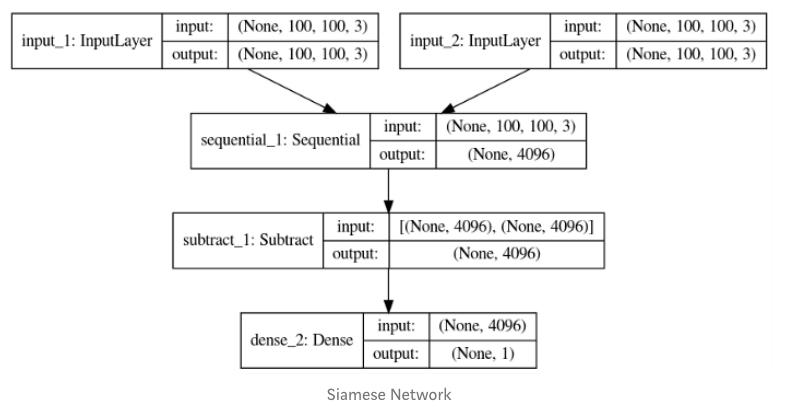

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 256)                  1607417   ['input_32[0][0]',            
                                                          6          'input_33[0][0]']            
                                                                                                  
 lambda_10 (Lambda)          (None, 256)                  0         ['sequential_10[0][0]',

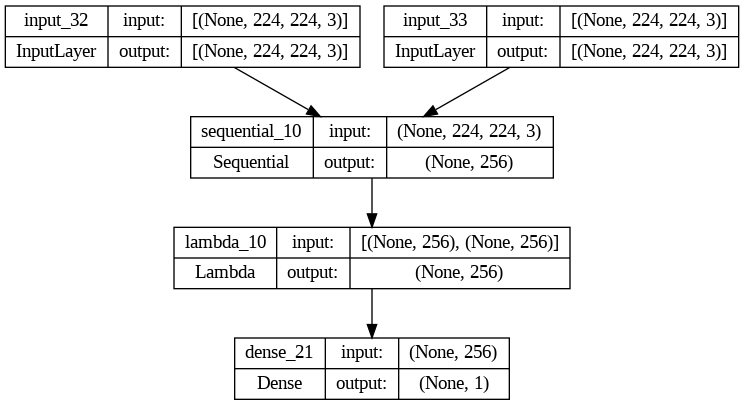

In [109]:
# Construindo a SNN
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import MobileNet


from keras.applications.vgg16 import VGG16

# Load VGG16 without the top FC Layers.
#vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#vgg_conv.trainable=False

# Load MobileNet
mobilenet_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_conv.trainable = False

input_shape = (224, 224, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

b_init = tensorflow.keras.initializers.RandomNormal(mean=0.5, stddev=1e-2)

model = Sequential()
model.add(mobilenet_conv)
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
siamese_net = Model([left_input, right_input], prediction)


'''
input_shape=(224, 224, 3)   # formato das imagens de entrada
left_input = Input(input_shape)
right_input = Input(input_shape)

# inicializando os bias
b_init = tensorflow.keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))

# pegando a saída (mapa de features) da rede do lado esquerdo
encoded_l = model(left_input)

# pegando a saída (mapa de features) da rede do lado direito
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# camada que calcula a diferença entre os mapas de características
#subtracted = keras.layers.Subtract()([encoded_l, encoded_r])

# camada que faz a predição de ser ou não da mesma categoria
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance)
siamese_net = Model([left_input, right_input], prediction)'''

# Freeze the layers except the last 2 layers
# layer in model.layers[:-2]:
#    layer.trainable = False

# compilando o modelo
optimizer= Adam(learning_rate=0.001)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)


# plotando o modelo
siamese_net.summary()
plot_model(siamese_net, show_shapes=True, show_layer_names=True)

N-way one-shot Learning ==> neste esquema de avaliação
consideramos N pares de imagens sendo que apenas um par é positivo (mesma categoria), os demais são negativos.

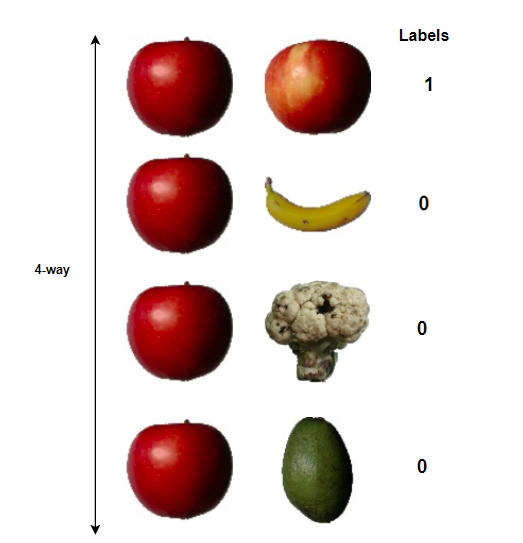

In [110]:
def nway_one_shot(model, n_way, n_val):
    temp_x = x_val
    temp_cat_list = category_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0

    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:
        j = np.random.choice(category_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 224, 224, 3)))
        temp.append(np.zeros((n_way, 224, 224, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]

            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(category_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(category_list[:i].flatten(), category_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(max(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy

Training model

In [111]:
epochs = 100   # quantidade de épocas
n_way = 20       # forma de avaliação (número de pares)
n_val = 100      # tamanho
batch_size = 32

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size)
#    print(batch_x[0].shape)
#    print(batch_y)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))

    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%250 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 99% Accuracy")
            #break

Epoch: 1 , Loss: 0.8447551727294922
Epoch: 2 , Loss: 0.6822366714477539
Epoch: 3 , Loss: 0.5265575647354126
Epoch: 4 , Loss: 0.537333607673645
Epoch: 5 , Loss: 0.556672215461731
Epoch: 6 , Loss: 0.48249393701553345
Epoch: 7 , Loss: 0.5598914623260498
Epoch: 8 , Loss: 0.4929271340370178
Epoch: 9 , Loss: 0.49339282512664795
Epoch: 10 , Loss: 0.4793877601623535
Epoch: 11 , Loss: 0.5001299977302551
Epoch: 12 , Loss: 0.5628103613853455
Epoch: 13 , Loss: 0.513052225112915
Epoch: 14 , Loss: 0.5429688692092896
Epoch: 15 , Loss: 0.5687979459762573
Epoch: 16 , Loss: 0.45276880264282227
Epoch: 17 , Loss: 0.5069726705551147
Epoch: 18 , Loss: 0.5110927820205688
Epoch: 19 , Loss: 0.4897138774394989
Epoch: 20 , Loss: 0.4632143974304199
Epoch: 21 , Loss: 0.43383675813674927
Epoch: 22 , Loss: 0.49322545528411865
Epoch: 23 , Loss: 0.5330767035484314
Epoch: 24 , Loss: 0.4540973901748657
Epoch: 25 , Loss: 0.4400247037410736
Epoch: 26 , Loss: 0.5626528859138489
Epoch: 27 , Loss: 0.4637194275856018
Epoch: 2

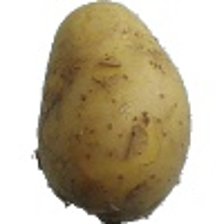

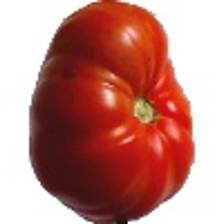

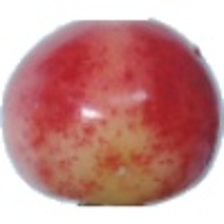

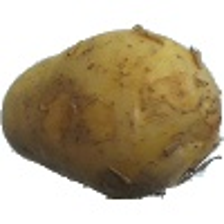

1/1 [==============================] - 1s 697ms/step
[0.18433153629302979, 0.2882458567619324, 0.48974889516830444]
2


In [112]:
# Testing with an specific image

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

temp=[]
temp.append(np.zeros((3, 224, 224, 3)))
temp.append(np.zeros((3, 224, 224, 3)))

q=91   # imagem de índice 91 - batata
a=41
b=535
c=90

temp[0][0]=x[q]
temp[0][1]=x[q]
temp[0][2]=x[q]

temp[1][0] = x[a]
temp[1][1] = x[b]
temp[1][2] = x[c]

im=x[q].copy()
im[:,:,[0,1,2]]=im[:,:,[2,1,0]]
cv2_imshow(im*255)

im=x[a].copy()
im[:,:,[0,1,2]]=im[:,:,[2,1,0]]
cv2_imshow(im*255)

im=x[b].copy()
im[:,:,[0,1,2]]=im[:,:,[2,1,0]]
cv2_imshow(im*255)

im=x[c].copy()
im[:,:,[0,1,2]]=im[:,:,[2,1,0]]
cv2_imshow(im*255)

result = siamese_net.predict(temp)

result = result.flatten().tolist()
print(result)
result_index = result.index(max(result))
print(result_index)

In [113]:
from google.colab.patches import cv2_imshow
import time
temp=[]
temp.append(np.zeros((1, 224, 224, 3)))
temp.append(np.zeros((1, 224, 224, 3)))

VP=VN=FP=FN=0

threshold = 0.5

start = time.time()
for i in range (0, 50):
    temp[0][0]=x_val[i]

    for j in range (0, 50):
        if (y_val[i] == y_val[j]):
            mesmo_individuo = True
        else:
            mesmo_individuo = False

        temp[1][0]=x_val[j]
        result = siamese_net.predict(temp)

 #       im=x_test[i]*255
 #       cv2_imshow(im)
 #       im1=x_test[j]*255
 #       cv2_imshow(im1)


        if (mesmo_individuo and result[0][0] > threshold):
            print(y_val[i], y_val[j], result[0][0], "OK  VP")
            VP=VP+1

        if (mesmo_individuo and result[0][0] < threshold):
            print(y_val[i], y_val[j], result[0][0], "erro  FN")
            FN=FN+1

        if (not mesmo_individuo and result[0][0] > threshold):
            print(y_val[i], y_val[j], result[0][0], "erro  FP")
            FP=FP+1

        if (not mesmo_individuo and result[0][0] < threshold):
            print(y_val[i], y_val[j], result[0][0], "Ok  VN")
            VN=VN+1

end = time.time()
print('Evaluation time: {}s'.format(round(end - start, 7)))

print("VP = ", VP)
print("VN = ", VN)
print("FP = ", FP)
print("FN = ", FN)

P=VP/(VP+FP)
R=VP/(VP+FN)


print("Acurácia: ", (VP+VN)/(VP+FP+FN+VN))
print("Precisão: ", P)
print("Revocação: ", R)
print("F_score: ", 2/(1/P + 1/R))

A saída de streaming foi truncada nas últimas 5000 linhas.
91 91 0.54648757 OK  VP
1/1 [==============================] - 0s 24ms/step
91 92 0.40209544 Ok  VN
1/1 [==============================] - 0s 25ms/step
91 92 0.4537742 Ok  VN
1/1 [==============================] - 0s 23ms/step
91 92 0.36465263 Ok  VN
1/1 [==============================] - 0s 26ms/step
91 92 0.42569876 Ok  VN
1/1 [==============================] - 0s 25ms/step
91 92 0.44913194 Ok  VN
1/1 [==============================] - 0s 22ms/step
91 93 0.21284695 Ok  VN
1/1 [==============================] - 0s 23ms/step
91 93 0.17183854 Ok  VN
1/1 [==============================] - 0s 24ms/step
91 93 0.19320966 Ok  VN
1/1 [==============================] - 0s 24ms/step
91 93 0.21021284 Ok  VN
1/1 [==============================] - 0s 26ms/step
91 93 0.17611213 Ok  VN
1/1 [==============================] - 0s 29ms/step
91 94 0.15675886 Ok  VN
1/1 [==============================] - 0s 25ms/step
91 94 0.22137596 Ok  VN
1/1 [=